# 全家便利商店食品輿論分析 (延續期中的內容)
- 社群媒體分析
- 授課教授：黃三益
- 組別：Group 7
- 組員：M114020013 黃于千、M114020015 秦苡軒、B084020034 謝旻臻、M114020055 吳均庭
- youtube 影片連結: https://youtu.be/5US8_WHd64w
## 大綱
1. About data
    - 1.1 資料基本介紹
    - 1.2 動機及分析方向
2. 資料前處理
    - 2.1 匯入資料
    - 2.2 清理資料
    - 2.3 jieba斷詞 & 移除停用字
3. LDA 主題模型
    + 3.1 訓練 LDA 模型
    + 3.2 查看 LDA 主題代表字
    + 3.3 查看 LDA 模型指標
    + 3.4 透過指標找出最佳主題數
4. LDA 視覺化呈現
    + 4.1 產生 LDAvis 結果
    + 4.2 查看 Document 主題時間上的分布
5. 社群網路圖
6. 結論

## 1. About data

### 1.1 資料基本介紹
- 資料來源：
    - 文字平台收集PTT
    - 來源：超商版、飲食疾患版、美食版、省錢版、女孩版
- 搜尋關鍵字：與 **全家美食** 相關的文章<br>
    - 如：全家食物、 全家再睡5分鐘、 全家SOMA、 Let’s Café、 全家署茗職茶...等文章
- 斷詞字典：jieba
- 資料時間：2019/01/01 ~ 2023/4/18

### 1.2 動機及分析方向
主要分析 ptt 上文章內容及網友相關討論。本次分析目的及動機主要為：  
- 動機：<br>
超商在台灣是一個極為普遍且重要的商業形態，提供各種日常所需商品和服務，並成為人們日常生活中不可或缺的一部分。  
同時，ptt 作為台灣最大的社群網站之一，匯集了眾多使用者，其中有許多人在 ptt 上討論和分享與超商相關的話題。  
因此，對 ptt 版上與超商相關貼文的研究，除了能讓我們了解消費者喜好外，也能幫助超商業者改善產品和服務，滿足消費者需求。
- 分析目的：  
    - (期中)  
        1. 瞭解消費者對全家便利商店食品的整體滿意度和評價，包括正面和負面評價。
        2. 分析消費者對全家便利商店食品的評價因素，例如味道、價格、品質、包裝、不同的聯名產品等，以及這些評價因素對消費者滿意度的影響。
        3. 研究消費者對全家便利商店食品的改進建議和期望，了解消費者希望全家便利商店在哪些方面進行改進，以提高產品和服務質量。 
    - (期末)  
        4. 探討超商在 ptt 社群中的知名度和討論熱度：分析超商相關貼文的數量、觸及的話題範疇和參與討論的使用者人數。  
        5. 探索超商相關貼文的互動模式和社群影響：分析 ptt 使用者之間在超商相關貼文中的互動，包括回覆、評論和分享等。了解社群對超商相關話題的討論模式、意見交流和影響力。

## 2. 資料前處理

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import math
from functools import reduce
from collections import Counter
from pprint import pprint
from datetime import datetime, timedelta
from collections import Counter, namedtuple

import jieba

import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
# import pyLDAvis.gensim_models
import pyLDAvis.gensim

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
%matplotlib inline

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/sklearn/utils/fixes.py:54: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if 'order' in inspect.getargspec(np.copy)[0]:
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/miniconda3/envs/TF

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
fprop = fm.FontProperties(fname="raw_data/SourceHanSansTW-Regular.otf")

# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 120

### 2.1 匯入資料

In [159]:
df = pd.read_csv('sna2023sPro_7_737d4b10d8_4.csv')
df = df.rename(columns={"artContent": "sentence"})
df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....   
1          2  https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87....   
2          3  https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8....   
3          4  https://www.ptt.cc/bbs/CVS/M.1546995940.A.156....   
4          5  https://www.ptt.cc/bbs/CVS/M.1547045068.A.571....   

              artTitle              artDate     artPoster artCatagory  \
0    [商品]全家奧地利咖啡、新貴派牛乳  2019-01-05 08:20:28    DoubleKang         CVS   
1        [商品]全家咖哩起司豬排堡  2019-01-05 23:39:29      nerolanx         CVS   
2  [討論]全家拿鐵改新配方，容量也變了？  2019-01-08 02:24:34      alwaysky         CVS   
3       [分享］全家茶葉蛋買到半熟蛋  2019-01-09 00:59:37    summerhsia         CVS   
4       [商品]全家福袋加萊爾富福袋  2019-01-09 14:38:26  jack99310349         CVS   

                                            sentence  \
0  (如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n【商品名稱/價格】：奧地利咖啡69...   
1  【商品名稱/價格】：咖哩起司豬排堡/49元\n\n\n【便利商店/廠商名稱】：金家/屏榮食品...   
2  自從全家改了黃金配方後，\n原本裝大熱拿剛好的保溫杯，\n（舊版裝完可以旋上杯蓋不溢出來）\...   
3  【便利商店名稱/廠商名稱】：全家便利商店\n\n我其實平常買茶葉蛋不會特別挑\n但最近好幾次...   
4  【商品名稱/價格】：福袋\n                  s\n【便利商店/廠商名稱】...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "betaku", "cm...  61.230.200.184   
1  [{"cmtStatus": "推", "cmtPoster": "lucicarr", "...     39.10.62.24   
2  [{"cmtStatus": "推", "cmtPoster": "lemenf1", "c...   42.77.174.192   
3  [{"cmtStatus": "→", "cmtPoster": "ConanKo", "c...   49.217.39.169   
4  [{"cmtStatus": "推", "cmtPoster": "mytoychiu", ...  114.136.100.49   

          insertedDate dataSource  
0  2019-03-07 02:31:37        ptt  
1  2019-03-07 02:32:05        ptt  
2  2019-03-07 02:32:05        ptt  
3  2019-03-07 02:32:05        ptt  
4  2019-03-07 02:32:27        ptt

### 2.2 清理資料

In [160]:
clear_df = df.copy()

# 去除有包含空值的筆數
clear_df.dropna(axis=0, how="any", inplace=True)

# 用'。'取代'\n\n'，並移除'\n'
clear_df = clear_df.replace("\\n\\n", "。", regex=True).replace("\n", "", regex=True)

# 移除內文中的網址
clear_df["sentence"] = (
    clear_df["sentence"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
    .replace(r"\d+", "", regex=True)
)

In [161]:
# 移除網址格式，只留下中文字
clear_df["sentence"] = clear_df["sentence"].str.replace("(http|https)://.*", "", regex=True)
clear_df["artTitle"] = clear_df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
clear_df["sentence"] = clear_df["sentence"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
clear_df["artTitle"] = clear_df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

In [162]:
clear_df.head()

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....   
1          2  https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87....   
2          3  https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8....   
3          4  https://www.ptt.cc/bbs/CVS/M.1546995940.A.156....   
4          5  https://www.ptt.cc/bbs/CVS/M.1547045068.A.571....   

          artTitle              artDate     artPoster artCatagory  \
0   商品全家奧地利咖啡新貴派牛乳  2019-01-05 08:20:28    DoubleKang         CVS   
1      商品全家咖哩起司豬排堡  2019-01-05 23:39:29      nerolanx         CVS   
2  討論全家拿鐵改新配方容量也變了  2019-01-08 02:24:34      alwaysky         CVS   
3     分享全家茶葉蛋買到半熟蛋  2019-01-09 00:59:37    summerhsia         CVS   
4     商品全家福袋加萊爾富福袋  2019-01-09 14:38:26  jack99310349         CVS   

                                            sentence  \
0  如有不清楚的項目可跳過或按刪除商品名稱價格奧地利咖啡特價但我買在原價新貴派牛乳單買優惠組合加...   
1      商品名稱價格咖哩起司豬排堡元便利商店廠商名稱金家屏榮食品規格內容物熱量如下評分分心得先上圖   
2  自從全家改了黃金配方後原本裝大熱拿剛好的保溫杯舊版裝完可以旋上杯蓋不溢出來但最近幾次買大熱拿...   
3  便利商店名稱廠商名稱全家便利商店我其實平常買茶葉蛋不會特別挑但最近好幾次都買到一半像鐵蛋一樣...   
4  商品名稱價格福袋便利商店廠商名稱全家及萊爾富規格內容物熱量廢評分心得忍不住還是買來試手氣結果...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "betaku", "cm...  61.230.200.184   
1  [{"cmtStatus": "推", "cmtPoster": "lucicarr", "...     39.10.62.24   
2  [{"cmtStatus": "推", "cmtPoster": "lemenf1", "c...   42.77.174.192   
3  [{"cmtStatus": "→", "cmtPoster": "ConanKo", "c...   49.217.39.169   
4  [{"cmtStatus": "推", "cmtPoster": "mytoychiu", ...  114.136.100.49   

          insertedDate dataSource  
0  2019-03-07 02:31:37        ptt  
1  2019-03-07 02:32:05        ptt  
2  2019-03-07 02:32:05        ptt  
3  2019-03-07 02:32:05        ptt  
4  2019-03-07 02:32:27        ptt

### 2.3 jieba斷詞 & 移除停用字

In [163]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")
jieba.load_userdict("./dict/user_dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 參數形式手動加入停用字
stopwords_manual = ["CtrlY", "JPTT", "XD", "Sent", "on", "my","from", "本來", "對面", "剛剛", "裡面", "那種", "這種", "算是", "上面", "現在", 
                    "知道", "一直", "一次", "一口", "一下", "一點", "一杯", "今天", "如有", "項目", "全家", "名稱", "商品", "印象", "以前", 
                    "東西", "還蠻", "iPhone", "希望", "搭配", "這款", "使用", "最近", "附近", "遇到", "看看", "文字",
                    "看到", "發現", "分為", "請問", "之後", "好像", "變成", "跳過", "刪除", "最後", "吃到", "變成", "直接", "目前", "有沒有", "便利商店"]
stopWords.extend(stopwords_manual)

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

clear_df["words"] = clear_df["sentence"].apply(getToken)
clear_df.head()

Building prefix dict from /home/minchen/Python/社媒/final_project/dict/dict.txt ...
Loading model from cache /tmp/jieba.u01319a39a5cb1a46adb882c223ef1353.cache
Loading model cost 0.724 seconds.
Prefix dict has been built successfully.


system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/CVS/M.1546676792.A.FB5....   
1          2  https://www.ptt.cc/bbs/CVS/M.1546731931.A.E87....   
2          3  https://www.ptt.cc/bbs/CVS/M.1546914637.A.7E8....   
3          4  https://www.ptt.cc/bbs/CVS/M.1546995940.A.156....   
4          5  https://www.ptt.cc/bbs/CVS/M.1547045068.A.571....   

          artTitle              artDate     artPoster artCatagory  \
0   商品全家奧地利咖啡新貴派牛乳  2019-01-05 08:20:28    DoubleKang         CVS   
1      商品全家咖哩起司豬排堡  2019-01-05 23:39:29      nerolanx         CVS   
2  討論全家拿鐵改新配方容量也變了  2019-01-08 02:24:34      alwaysky         CVS   
3     分享全家茶葉蛋買到半熟蛋  2019-01-09 00:59:37    summerhsia         CVS   
4     商品全家福袋加萊爾富福袋  2019-01-09 14:38:26  jack99310349         CVS   

                                            sentence  \
0  如有不清楚的項目可跳過或按刪除商品名稱價格奧地利咖啡特價但我買在原價新貴派牛乳單買優惠組合加...   
1      商品名稱價格咖哩起司豬排堡元便利商店廠商名稱金家屏榮食品規格內容物熱量如下評分分心得先上圖   
2  自從全家改了黃金配方後原本裝大熱拿剛好的保溫杯舊版裝完可以旋上杯蓋不溢出來但最近幾次買大熱拿...   
3  便利商店名稱廠商名稱全家便利商店我其實平常買茶葉蛋不會特別挑但最近好幾次都買到一半像鐵蛋一樣...   
4  商品名稱價格福袋便利商店廠商名稱全家及萊爾富規格內容物熱量廢評分心得忍不住還是買來試手氣結果...   

                                          artComment            e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "betaku", "cm...  61.230.200.184   
1  [{"cmtStatus": "推", "cmtPoster": "lucicarr", "...     39.10.62.24   
2  [{"cmtStatus": "推", "cmtPoster": "lemenf1", "c...   42.77.174.192   
3  [{"cmtStatus": "→", "cmtPoster": "ConanKo", "c...   49.217.39.169   
4  [{"cmtStatus": "推", "cmtPoster": "mytoychiu", ...  114.136.100.49   

          insertedDate dataSource  \
0  2019-03-07 02:31:37        ptt   
1  2019-03-07 02:32:05        ptt   
2  2019-03-07 02:32:05        ptt   
3  2019-03-07 02:32:05        ptt   
4  2019-03-07 02:32:27        ptt   

                                               words  
0  [清楚, 價格, 奧地利, 咖啡, 特價, 原價, 新貴, 牛乳, 單買, 優惠, 組合, ...  
1  [價格, 咖哩, 起司, 豬排, 堡元, 廠商, 屏榮, 食品, 規格, 內容物, 熱量, ...  
2  [改了, 黃金, 配方, 裝大熱, 保溫杯, 舊版, 裝完, 旋上, 杯蓋, 溢出來, 幾次...  
3  [廠商, 平常, 茶葉蛋, 特別, 幾次, 買到, 一半像, 鐵蛋, 特別, 這篇, 廢文,...  
4  [價格, 福袋, 廠商, 萊爾富, 規格, 內容物, 熱量, 評分, 心得, 忍不住, 買來...

## 3. LDA 主題模型

將文章斷詞結果儲存為 list 資料形態，並查看結果

In [8]:
docs = clear_df['words'].to_list()
for i in range(2,5):
    print("第 " + str(i+1) + " 篇文章前 5 個字：")
    for j in range(0,5):
        print(docs[i][j], end=' ')
    print('\n')

第 3 篇文章前 5 個字：
改了 黃金 配方 裝大熱 保溫杯 

第 4 篇文章前 5 個字：
廠商 平常 茶葉蛋 特別 幾次 

第 5 篇文章前 5 個字：
價格 福袋 廠商 萊爾富 規格 



將斷詞結果建構語料庫 (corpus)，利用語料庫把每篇文章數字化  
每篇文章、每個詞彙都被賦予一個 ID 及頻率 (word_id，word_frequency)

In [13]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print('資料集字典：')
print(dictionary)

資料集字典：
Dictionary<1252 unique tokens: ['不可', '價格', '優惠', '內容', '內容物']...>


In [10]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

### 3.1 訓練 LDA 模型

將主題數設成 5

In [11]:
ldamodel = LdaMulticore(
    workers = 48,
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=5, # 生成幾個主題數
    passes = 1000, # 訓練次數
    random_state=2023, # 亂數
)

### 3.2 查看 LDA 主題代表字

In [12]:
ldamodel.print_topics()

[(0,
  '0.069*"價格" + 0.048*"熱量" + 0.048*"廠商" + 0.045*"內容物" + 0.045*"規格" + 0.037*"心得" + 0.034*"評分" + 0.016*"推薦" + 0.016*"標示" + 0.015*"大卡"'),
 (1,
  '0.093*"霜淇淋" + 0.056*"口味" + 0.019*"草莓" + 0.019*"巧克力" + 0.014*"聯名" + 0.014*"抹茶" + 0.013*"店員" + 0.012*"牛奶" + 0.012*"餅乾" + 0.011*"起司"'),
 (2,
  '0.031*"麵包" + 0.029*"泡芙" + 0.027*"飯糰" + 0.026*"巧克力" + 0.017*"甜點" + 0.017*"起司" + 0.015*"蛋糕" + 0.014*"口味" + 0.013*"味道" + 0.013*"檸檬"'),
 (3,
  '0.063*"活動" + 0.027*"內容" + 0.021*"時間" + 0.019*"茶葉蛋" + 0.017*"兌換" + 0.014*"廠商" + 0.014*"圖文" + 0.013*"點數" + 0.012*"單獨" + 0.012*"會員"'),
 (4,
  '0.055*"咖啡" + 0.039*"拿鐵" + 0.026*"優惠" + 0.023*"店員" + 0.022*"美式" + 0.012*"回饋" + 0.011*"活動" + 0.010*"原價" + 0.010*"環保杯" + 0.009*"經典"')]

根據每個主題的詞彙分佈來猜測，可分為以下主題：  

主題一：版上對於超商食物主要討論價格、熱量、內容物以及大家的評分和心得  
主題二：霜淇淋相關的主題  
主題三：主要討論麵包、甜點相關的產品  
主題四：超商舉辦的活動，包括會員點數、兌換商品等等  
主題五：咖啡相關的主題

### 3.3 查看 LDA 模型指標

Pointwise Mutual Information: 自然語言處理中，想要探討兩個字之間是否存在某種關係，數字越大越好。  
perplexity: 評估指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [18]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

這個主題的 PMI score:  -0.24435270494058145


In [19]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
print('這個主題的 Perplexity Score: ', perplexity)

這個主題的 Perplexity Score:  -6.116581123767189


### 3.4 透過指標找出最佳主題數

In [31]:
t0 = time.time()

topic_num_list = np.arange(2, 11)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaMulticore(    # LdaModel
            workers = 48,
            corpus = corpus,
            num_topics = topic_num ,
            id2word=dictionary,
            random_state = 2023,
            passes=5 # 訓練次數
            )
    
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

花費時間: 71.24412298202515 sec


主題數從 2 ~ 10 的結果

In [32]:
result = pd.DataFrame(result)
result

topic_num  perplexity       pmi
0          2  507.903141 -0.097570
1          3  506.002022 -0.211693
2          4  495.810168 -0.161998
3          5  506.854055 -0.157422
4          6  513.942313 -0.186285
5          7  513.222669 -0.168168
6          8  506.548345 -0.173177
7          9  516.709978 -0.191695
8         10  524.880578 -0.174458

perplexity 的趨勢

<AxesSubplot:xlabel='topic_num'>

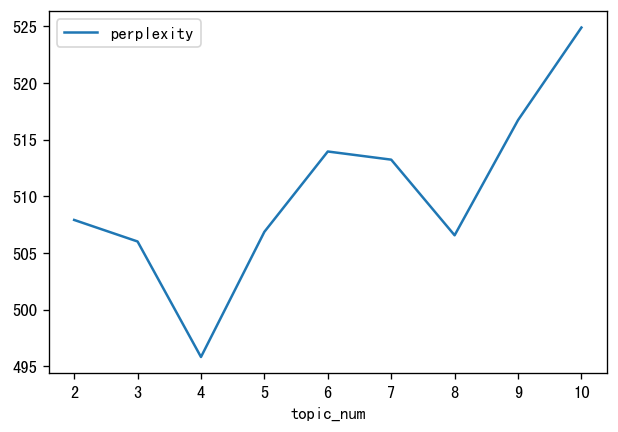

In [33]:
result.plot.line(x='topic_num', y='perplexity', label='perplexity')

pmi 的趨勢

<AxesSubplot:xlabel='topic_num'>

/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/miniconda3/envs/TF1/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


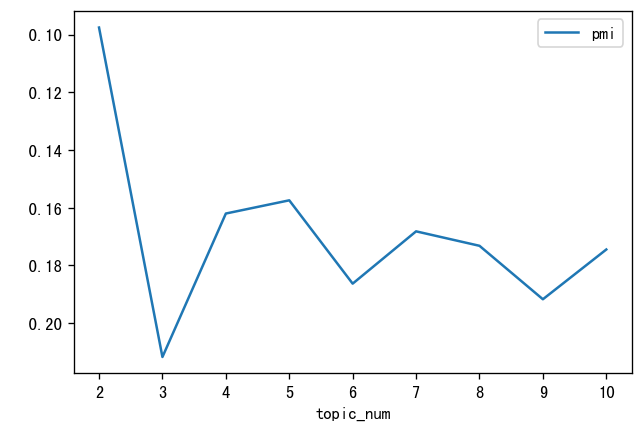

In [34]:
result.plot.line(x='topic_num', y='pmi', label='pmi')

## 4. LDA 視覺化呈現

### 4.1 產生 LDAvis 結果

根據上面的結果，我們用 perplexity 最低、pmi 第三高的主題數 4 來做 LDAvis 的結果範例

In [35]:
best_model = LdaMulticore(
    workers = 48,
    corpus = corpus,
    num_topics = 4,
    id2word=dictionary,
    random_state = 2023,
    passes = 1000, # 訓練次數
    )

In [178]:
best_model.print_topics()

[(0,
  '0.066*"價格" + 0.048*"廠商" + 0.046*"熱量" + 0.043*"內容物" + 0.043*"規格" + 0.035*"心得" + 0.033*"評分" + 0.016*"味道" + 0.015*"推薦" + 0.015*"標示"'),
 (1,
  '0.072*"霜淇淋" + 0.047*"口味" + 0.019*"巧克力" + 0.017*"店員" + 0.015*"草莓" + 0.015*"牛奶" + 0.013*"抹茶" + 0.012*"聯名" + 0.010*"圖文" + 0.010*"餅乾"'),
 (2,
  '0.025*"麵包" + 0.022*"飯糰" + 0.018*"巧克力" + 0.015*"泡芙" + 0.013*"回饋" + 0.012*"檸檬" + 0.012*"甜點" + 0.011*"便當" + 0.010*"友善食光" + 0.009*"小七"'),
 (3,
  '0.048*"咖啡" + 0.034*"活動" + 0.033*"拿鐵" + 0.024*"優惠" + 0.019*"美式" + 0.015*"店員" + 0.012*"兌換" + 0.011*"會員" + 0.011*"買一送一" + 0.010*"時間"')]

根據最佳的主題模型每個主題的詞彙分佈來猜測，可分為以下主題：  

主題一：版上對於超商食物主要討論價格、熱量、內容物以及大家的評分和心得  
主題二：霜淇淋相關的主題  
主題三：主要討論麵包、甜點相關的產品  
主題四：咖啡相關的主題

In [179]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
pyLDAvis.save_html(p,'ldaVis.html')
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.315409  0.061553       1        1  41.223880
3      0.183192  0.206598       2        1  25.554176
2      0.046314 -0.116251       3        1  17.173189
1      0.085903 -0.151900       4        1  16.048755, topic_info=     Term        Freq       Total Category  logprob  loglift
1      價格  778.000000  778.000000  Default  30.0000  30.0000
136   霜淇淋  362.000000  362.000000  Default  29.0000  29.0000
14     熱量  542.000000  542.000000  Default  28.0000  28.0000
7      咖啡  348.000000  348.000000  Default  27.0000  27.0000
4     內容物  507.000000  507.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
1016   歐蕾   22.143272   37.256455   Topic4  -5.3263   1.3092
75     味道   33.863176  243.280295   Topic4  -4.9015  -0.1423
105    推出   27.996665  119.671110   Topic4  -5.0917   0.3769
18     網址   21.375649   35.345296   Topic4  -5.3615   1.3266
28     起司   25.407372  111.133789   Topic4  -5.1888   0.3538

[243 rows x 6 columns], token_table=      Topic      Freq Term
term                      
138       3  0.041939   一支
138       4  0.922660   一支
475       1  0.963245   一款
511       3  0.973173  三明治
0         1  0.072266   不可
...     ...       ...  ...
471       3  0.817928   鮮食
308       3  0.991747   麵包
202       2  0.816062   點數
202       3  0.170804   點數
1083      1  0.987769  鼎泰豐

[332 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

從上圖的結果我們可以發現，主題 1 與主題 2 具有主題的唯一性，而主題 3 與主題 4 兩個主題則比較相似。

### 4.2 查看 Document 主題時間上的分布

In [165]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

# 把每篇文章的主題分佈存下來
m_theta = corpus2csc(topics_doc).T.toarray()
print(m_theta)

# 找出 probabilities 最大的主題
clear_df['topic_label'] = m_theta.argmax(axis=1) + 1

[[0.33198038 0.3822476  0.         0.27641052]
 [0.94546288 0.01796102 0.01866855 0.01790753]
 [0.0188783  0.01897237 0.23140685 0.73074251]
 ...
 [0.02203464 0.01961371 0.02118591 0.9371658 ]
 [0.03157122 0.71085793 0.22583209 0.03173876]
 [0.0389966  0.88187706 0.03855751 0.04056885]]


每一個列代表一個文章的主題分布

In [166]:
clear_df['topic_label'].value_counts()

1    520
4    269
2    134
3     98
Name: topic_label, dtype: int64

查看各個主題各自有多少文章

In [169]:
# 將 artDate 轉換為年加月
# df['month_year'] = df['date_column'].dt.to_period('M')
clear_df['artDate'] = pd.to_datetime(clear_df['artDate'])
clear_df['artDate'] = clear_df['artDate'].dt.to_period('M')

In [170]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':clear_df.groupby(['artDate','topic_label']).size()
})

date_topic = date_topic.reset_index()
date_topic = date_topic.groupby(['artDate','topic_label']).sum().reset_index()

In [174]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic_label').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic1', 'topic2', 'topic3', 'topic4']
date_df = date_df.set_index('artDate')
date_df.head()

topic1  topic2  topic3  topic4
artDate                                
2019-01     7.0     6.0     1.0     5.0
2019-02     5.0     1.0     1.0     3.0
2019-03     3.0     1.0     0.0     1.0
2019-04     2.0     0.0     1.0     6.0
2019-05     9.0     4.0     3.0     5.0

每個月的文章主題數量

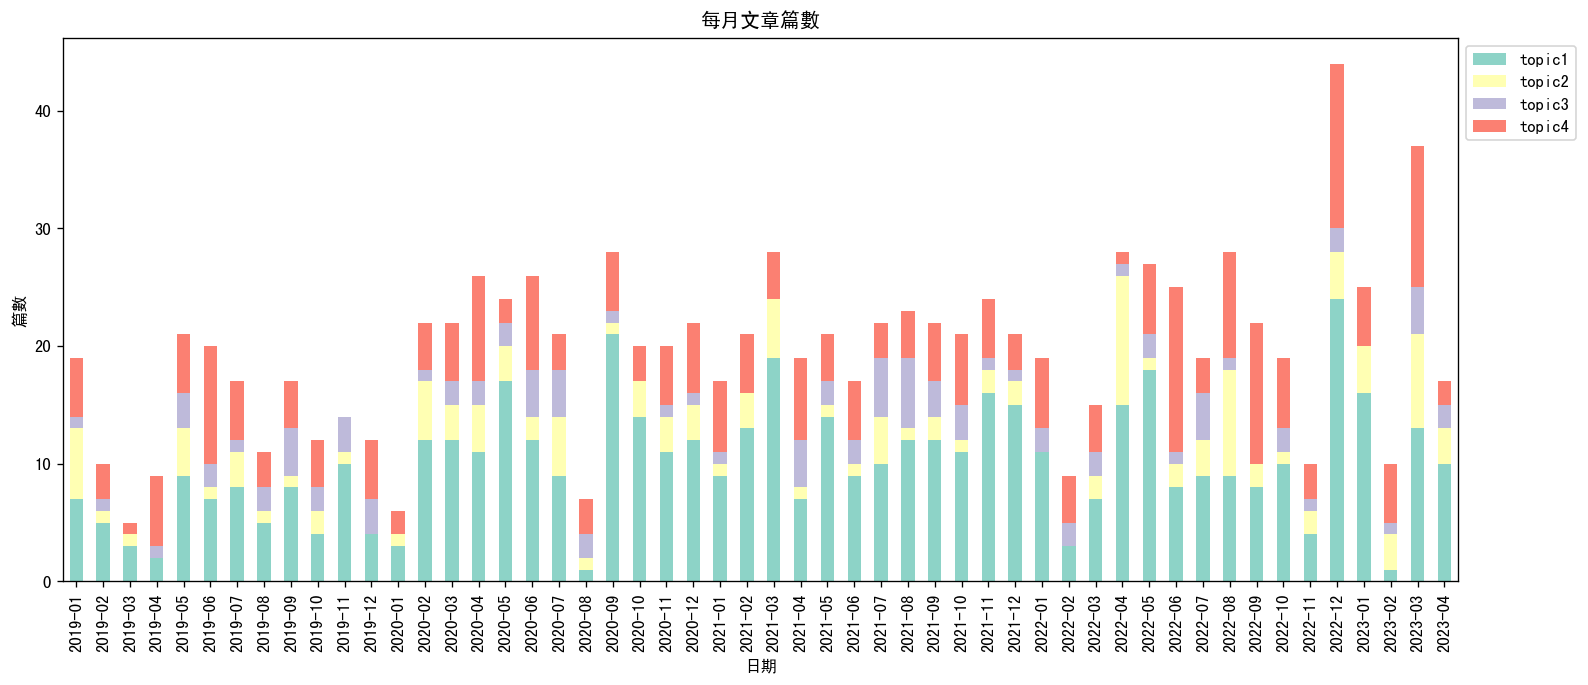

In [175]:
fig, ax = plt.subplots(figsize=(15, 6))
date_df.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

plt.title('每月文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置
plt.show()

我們可以看出在 2022-12 的討論非常熱烈，而整體來說 topic1 的討論度最高，也就是說相較於超商的其他資訊，大家更關注的是版上對於超商食物的價格、熱量、內容物等資訊的評分與心得

In [176]:
clear_df.groupby(clear_df['artDate'])['topic_label'].value_counts(normalize=True)
date_topic = clear_df.groupby(clear_df['artDate'])['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label         1         2         3         4
artDate                                            
2019-01      0.368421  0.315789  0.052632  0.263158
2019-02      0.500000  0.100000  0.100000  0.300000
2019-03      0.600000  0.200000       NaN  0.200000
2019-04      0.222222       NaN  0.111111  0.666667
2019-05      0.428571  0.190476  0.142857  0.238095

每個月的文章主題比例

<AxesSubplot:xlabel='artDate'>

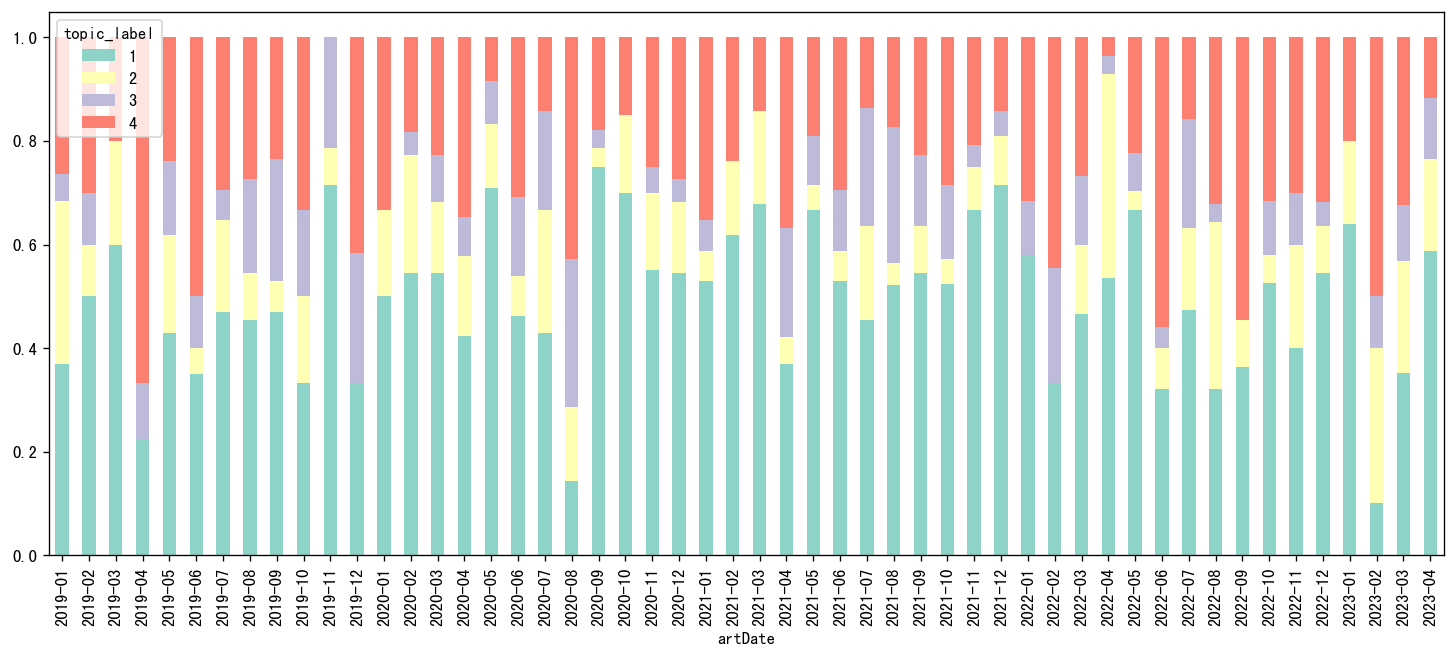

In [177]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

從比例來看也是 topic1 的討論占最多

## 5. 社群網路圖

### 從主題模型看出使用者的討論方向後, 接下來我們著重在使用者的分析上, 研究這個版的社群。

In [45]:
import pandas as pd
import numpy as np
import pyvis
import networkx as nx
import matplotlib.pyplot as plt
# Show network.png
from IPython.display import Image

In [46]:
raw_data = pd.read_csv('sna2023sPro_7_737d4b10d8_4.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/8), random_state=0)
print(raw_data.shape)
raw_data.head()


(127, 11)


system_id                                             artUrl  \
928        929  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   
76          77  https://www.ptt.cc/bbs/CVS/M.1562574756.A.127....   
613        614  https://www.ptt.cc/bbs/CVS/M.1649256796.A.0F4....   
635        636  https://www.ptt.cc/bbs/CVS/M.1651718541.A.7C3....   
384        385  https://www.ptt.cc/bbs/CVS/M.1614255256.A.8E6....   

                   artTitle              artDate   artPoster  artCatagory  \
928  [情報]全家霜淇淋、7-11燕麥拿鐵買一送一  2021-10-29 15:53:43     m292532  Lifeismoney   
76             [商品]全家鐵觀音霜淇淋  2019-07-08 08:26:33     ninewei          CVS   
613         [商品]全家再睡五分鐘紅烏歐蕾  2022-04-06 22:53:14  z04xu4fmp6          CVS   
635          [商品]全家古娃娃泰奶起司塔  2022-05-05 10:42:19     lise640          CVS   
384            [商品]全家起司塔霜淇林  2021-02-25 20:14:12      halulu          CVS   

                                            artContent  \
928  【活動名稱】：\n\n全家-「全品項」霜淇淋買一送一\n\n7-11-冰燕麥拿鐵買一送一\n...   
76   【商品名稱/價格】：\n全家鐵觀音霜淇淋/39元/中部限定\n\n【便利商店/廠商名稱】：\...   
613  【商品名稱/價格】：\n再睡五分鐘 紅烏歐蕾 $35，兩件$65(原價$38)\n\n【便利...   
635  【商品名稱/價格】：泰奶起司塔 48元\n(區域型商品請註明 試吃試用品請標示價格0元)\n...   
384  (如有不清楚的項目,可跳過,或按 Ctrl+Y 刪除)\n【商品名稱/價格】：霜淇林/2支5...   

                                            artComment             e_ip  \
928  [{"cmtStatus": "→", "cmtPoster": "Ken52039", "...    110.28.130.88   
76   [{"cmtStatus": "推", "cmtPoster": "MAGODAJAN", ...     39.9.171.239   
613  [{"cmtStatus": "推", "cmtPoster": "opple30340",...   223.137.183.96   
635  [{"cmtStatus": "推", "cmtPoster": "asd1214", "c...  114.136.250.103   
384  [{"cmtStatus": "→", "cmtPoster": "Jonghwa", "c...   114.136.217.93   

            insertedDate dataSource  
928  2021-10-30 01:00:14        ptt  
76   2019-12-01 04:10:34        ptt  
613  2022-04-07 01:08:05        ptt  
635  2022-05-06 01:07:46        ptt  
384  2021-02-26 00:11:36        ptt

In [47]:
#parse comment

def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))

{'cmtStatus': '→', 'cmtPoster': 'Ken52039', 'cmtContent': ':燕麥奶快過期了，大家幫幫忙', 'cmtDate': '2021-10-29 15:56:00'}
{'cmtStatus': '推', 'cmtPoster': 'jtch', 'cmtContent': ':可惡不上新口味', 'cmtDate': '2021-10-29 16:05:00'}
{'cmtStatus': '→', 'cmtPoster': 'Flyroach', 'cmtContent': ':霜淇淋用電子票券也是買一送一嗎', 'cmtDate': '2021-10-29 16:07:00'}
{'cmtStatus': '推', 'cmtPoster': 'Jintsu', 'cmtContent': ':現在還是水果口味喔pass...附近都單口味', 'cmtDate': '2021-10-29 16:10:00'}
{'cmtStatus': '→', 'cmtPoster': 'bee5408', 'cmtContent': ':我要美式', 'cmtDate': '2021-10-29 16:11:00'}
{'cmtStatus': '→', 'cmtPoster': 'jtch', 'cmtContent': ':想找西瓜的', 'cmtDate': '2021-10-29 16:16:00'}
{'cmtStatus': '→', 'cmtPoster': 'knosmund', 'cmtContent': ':現在都要加燕麥', 'cmtDate': '2021-10-29 16:21:00'}
{'cmtStatus': '推', 'cmtPoster': 'cb10', 'cmtContent': ':西瓜真的不行...快換掉', 'cmtDate': '2021-10-29 16:29:00'}
{'cmtStatus': '推', 'cmtPoster': 'pearlsally', 'cmtContent': ':燕麥加之前請店員搖一下會差很多', 'cmtDate': '2021-10-29 16:31:00'}
{'cmtStatus': '→', 'cmtPoster': 'Jimmywi

In [48]:
raw_data = raw_data.explode(['artComter','artStatus'])
social_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
social_data.head(10)


artUrl artPoster   artComter  \
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532    Ken52039   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532        jtch   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532    Flyroach   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532      Jintsu   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532     bee5408   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532        jtch   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532    knosmund   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532        cb10   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532  pearlsally   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...   m292532    Jimmywin   

    artStatus  
928         →  
928         推  
928         →  
928         推  
928         →  
928         →  
928         →  
928         推  
928         推  
928         →

In [49]:
social_data

artUrl   artPoster  \
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...     m292532   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...     m292532   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...     m292532   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...     m292532   
928  https://www.ptt.cc/bbs/Lifeismoney/M.163549402...     m292532   
..                                                 ...         ...   
747  https://www.ptt.cc/bbs/CVS/M.1669644919.A.72C....  jane060921   
747  https://www.ptt.cc/bbs/CVS/M.1669644919.A.72C....  jane060921   
747  https://www.ptt.cc/bbs/CVS/M.1669644919.A.72C....  jane060921   
747  https://www.ptt.cc/bbs/CVS/M.1669644919.A.72C....  jane060921   
747  https://www.ptt.cc/bbs/CVS/M.1669644919.A.72C....  jane060921   

       artComter artStatus  
928     Ken52039         →  
928         jtch         推  
928     Flyroach         →  
928       Jintsu         推  
928      bee5408         →  
..           ...       ...  
747     pink0518         推  
747     yamyrose         推  
747      fonitin         推  
747  a0939877325         推  
747       jascat         →  

[6100 rows x 4 columns]

### 可以看到, 就算我們已經從 1000多筆資料sample 1/8的資料, 每個貼文下還是有很多留言, 可見大家對於超商的食物討論是蠻踴躍的。

### 所以我們決定只分析討論度前10的貼文

In [50]:
# count how many comments under each article
social_data['artUrl'].value_counts()

# select top 10 articles with most comments
social_data = social_data[social_data['artUrl'].isin(social_data['artUrl'].value_counts().head(10).index)]
social_data.head()

artUrl artPoster artComter  \
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove  kkii9960   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove     duduf   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove    jilily   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove    jilily   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove   Paradox   

   artStatus  
28         推  
28         推  
28         推  
28         →  
28         推

In [66]:
social_data

artUrl    artPoster  \
28   https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....     mikelove   
28   https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....     mikelove   
28   https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....     mikelove   
28   https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....     mikelove   
28   https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....     mikelove   
..                                                 ...          ...   
958  https://www.ptt.cc/bbs/Lifeismoney/M.166087208...  sun24220499   
958  https://www.ptt.cc/bbs/Lifeismoney/M.166087208...  sun24220499   
958  https://www.ptt.cc/bbs/Lifeismoney/M.166087208...  sun24220499   
958  https://www.ptt.cc/bbs/Lifeismoney/M.166087208...  sun24220499   
958  https://www.ptt.cc/bbs/Lifeismoney/M.166087208...  sun24220499   

       artComter artStatus  
28      kkii9960         推  
28         duduf         推  
28        jilily         推  
28        jilily         →  
28       Paradox         推  
..           ...       ...  
958      rkbands         推  
958      CashCow         推  
958      barkids         推  
958      barkids         →  
958  momoko51244         推  

[3328 rows x 4 columns]

In [51]:
# 建立邊的資料
import random


po_df = social_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]
re_df = social_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]



def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
re_df = re_df.groupby(['src','dis']).sum().reset_index()

# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)



In [52]:
re_df

src                                                dis  weight  \
0              AAU  https://www.ptt.cc/bbs/Lifeismoney/M.159131853...       2   
1          ACHANEW  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
2          AKB5566  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
3          AKIRA22  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
4          ARCMOON  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
...            ...                                                ...     ...   
2192  zxc794613zxc  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
2193    zxnstu3104  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   
2194    zxy5566188  https://www.ptt.cc/bbs/Lifeismoney/M.162555120...       2   
2195      zz822321  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       1   
2196      zzzzzlss  https://www.ptt.cc/bbs/Lifeismoney/M.155625107...       2   

      color  
0     green  
1     green  
2     green  
3     green  
4     green  
...     ...  
2192  green  
2193  green  
2194  green  
2195  green  
2196  green  

[2197 rows x 4 columns]

In [53]:
# 人為綠色節點
# po文為橘色節點

netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout
netWork.repulsion()

netWork.save_graph('network.html')

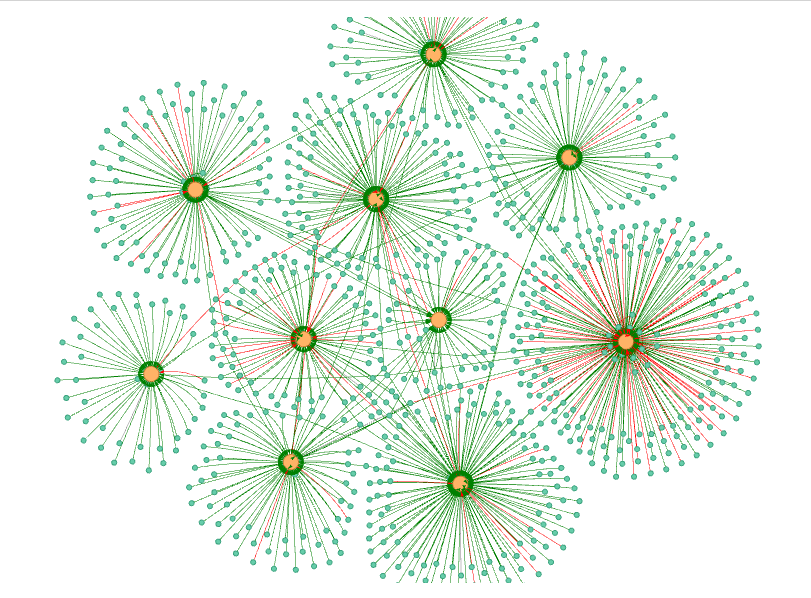

In [65]:
Image(filename='network.png')

### 可以看到右邊有一個節點的評論很多, 而且其中含有很多紅線, 所以我們決定進去貼文看是什麼原因導致這樣的結果。

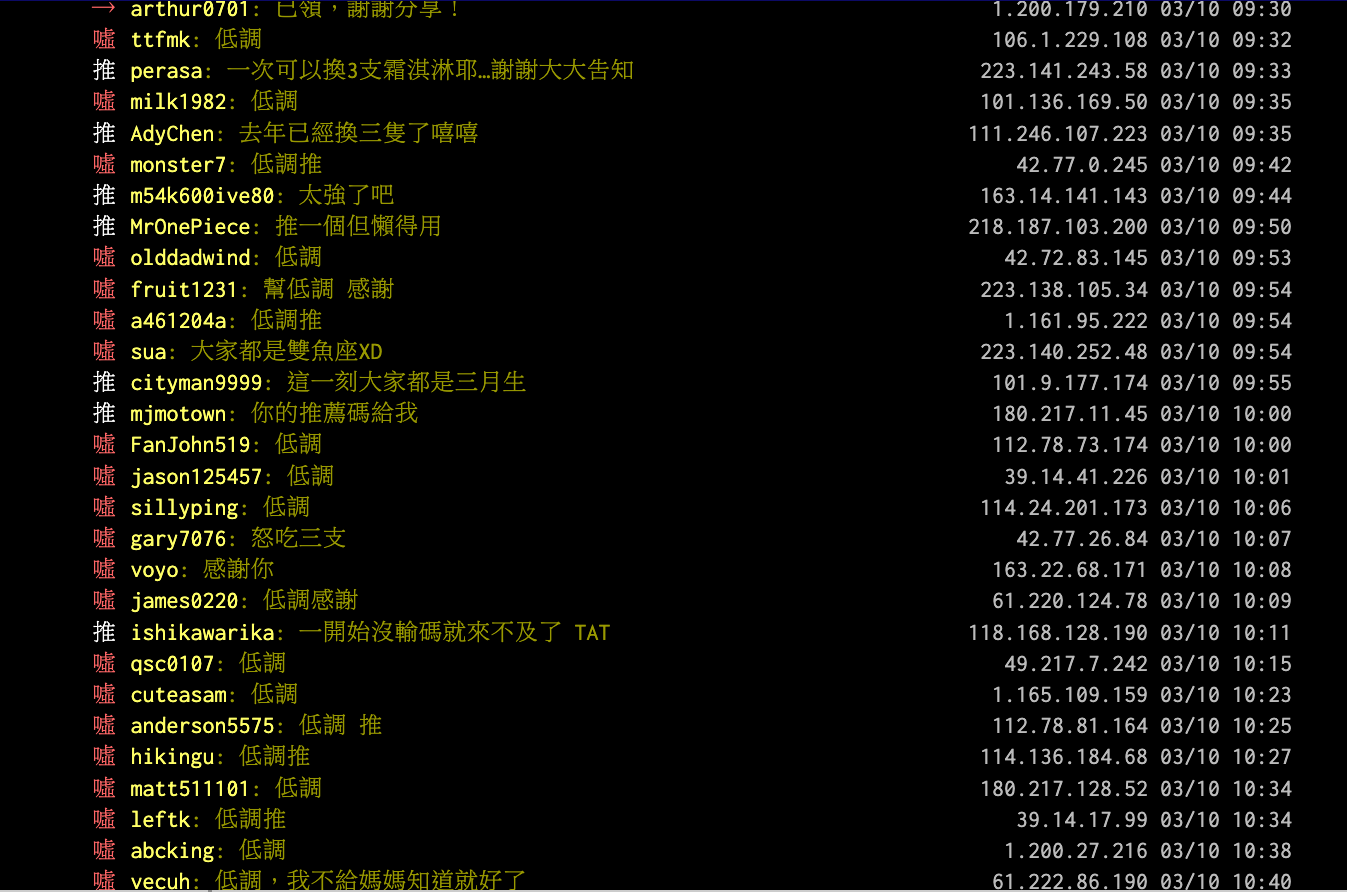

In [54]:
# Show ptt.png
Image(filename='ptt.png')

### 結果發現這個貼文是在教大家如何在超商領取免費的冰淇淋或者電子票卷, 大家為了不讓這則貼文太多推, 所以所有人都噓這篇貼文，但事實上這則貼文應該是非常正面的。

In [55]:
pos_cmt = social_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

artUrl artPoster    artComter  \
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove     kkii9960   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove        duduf   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove       jilily   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove       jilily   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove      Paradox   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove  qqchristine   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove  qqchristine   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove          neb   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove   peterhsuan   
28  https://www.ptt.cc/bbs/CVS/M.1551684428.A.0E1....  mikelove          neb   

   artStatus  
28         推  
28         推  
28         推  
28         →  
28         推  
28         推  
28         →  
28         推  
28         推  
28         推

In [56]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

artComter artPoster  score
0              AAU   hydroer      2
1          ACHANEW  andriano      2
2          AKB5566  andriano      2
3          AKIRA22  andriano      2
4          ARCMOON  andriano      2
...            ...       ...    ...
2192  zxc794613zxc  andriano      2
2193    zxnstu3104  andriano      2
2194    zxy5566188    jou705      2
2195      zz822321  andriano      1
2196      zzzzzlss  andriano      2

[2097 rows x 3 columns]

In [57]:
pers = np.unique(pos_cmt[['artComter', 'artPoster']])
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T



(1944, 1944)


In [58]:
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array,node_id:list,node_type:list=None,node_value:list = None,directed = True,edge_color=None) -> pyvis.network.Network:

  if directed != True:
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    else:
      print('matrix is not Symmetric')
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  else:
    node_color_map = {}
    for i in set(node_type):
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)
  if edge_color == None:
    edge_color = random_color()
  edge_color = random_color()
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')
  
  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net


In [59]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')



In [60]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type)

net.save_graph('pers_network.html')

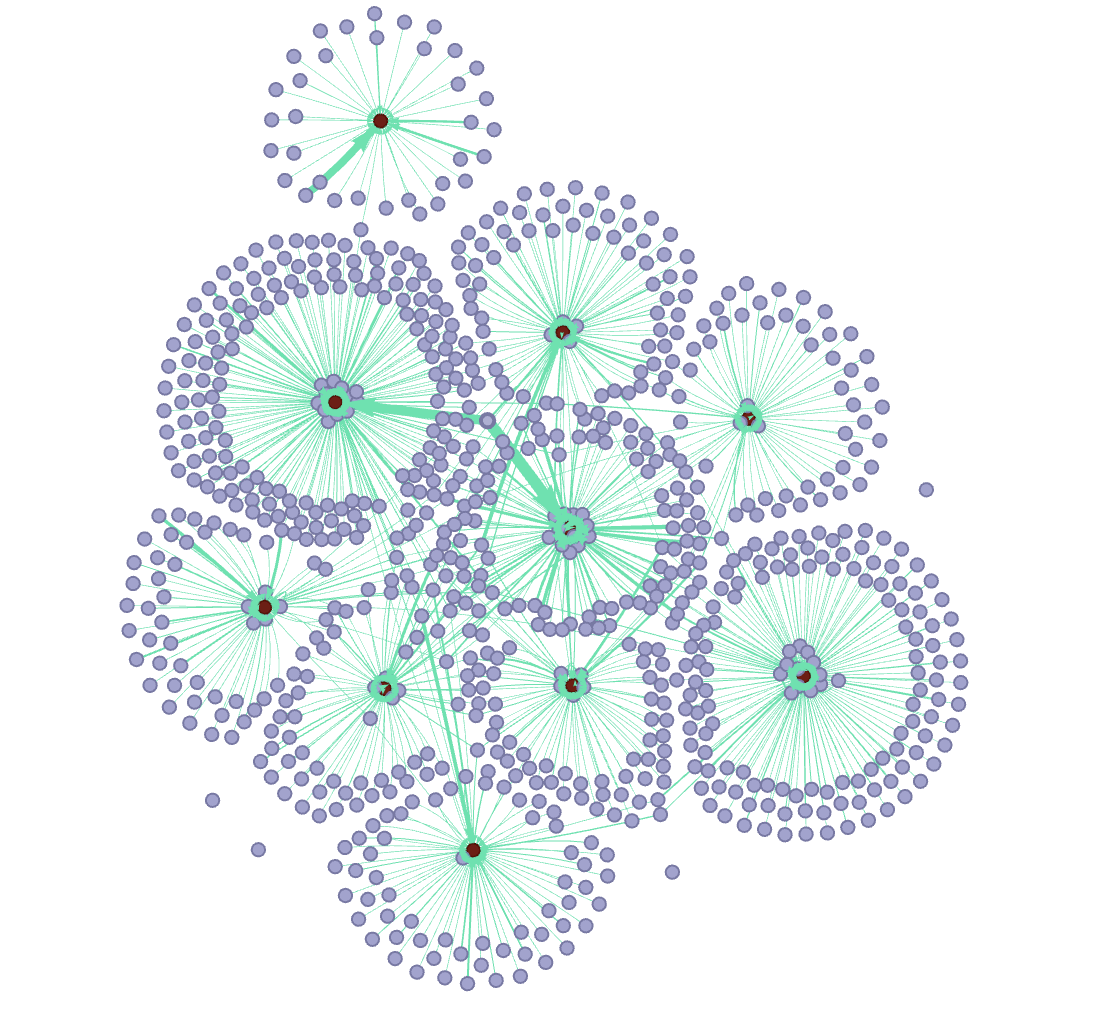

In [61]:
## Show pers_netWork.png
Image(filename='pers_network.png')

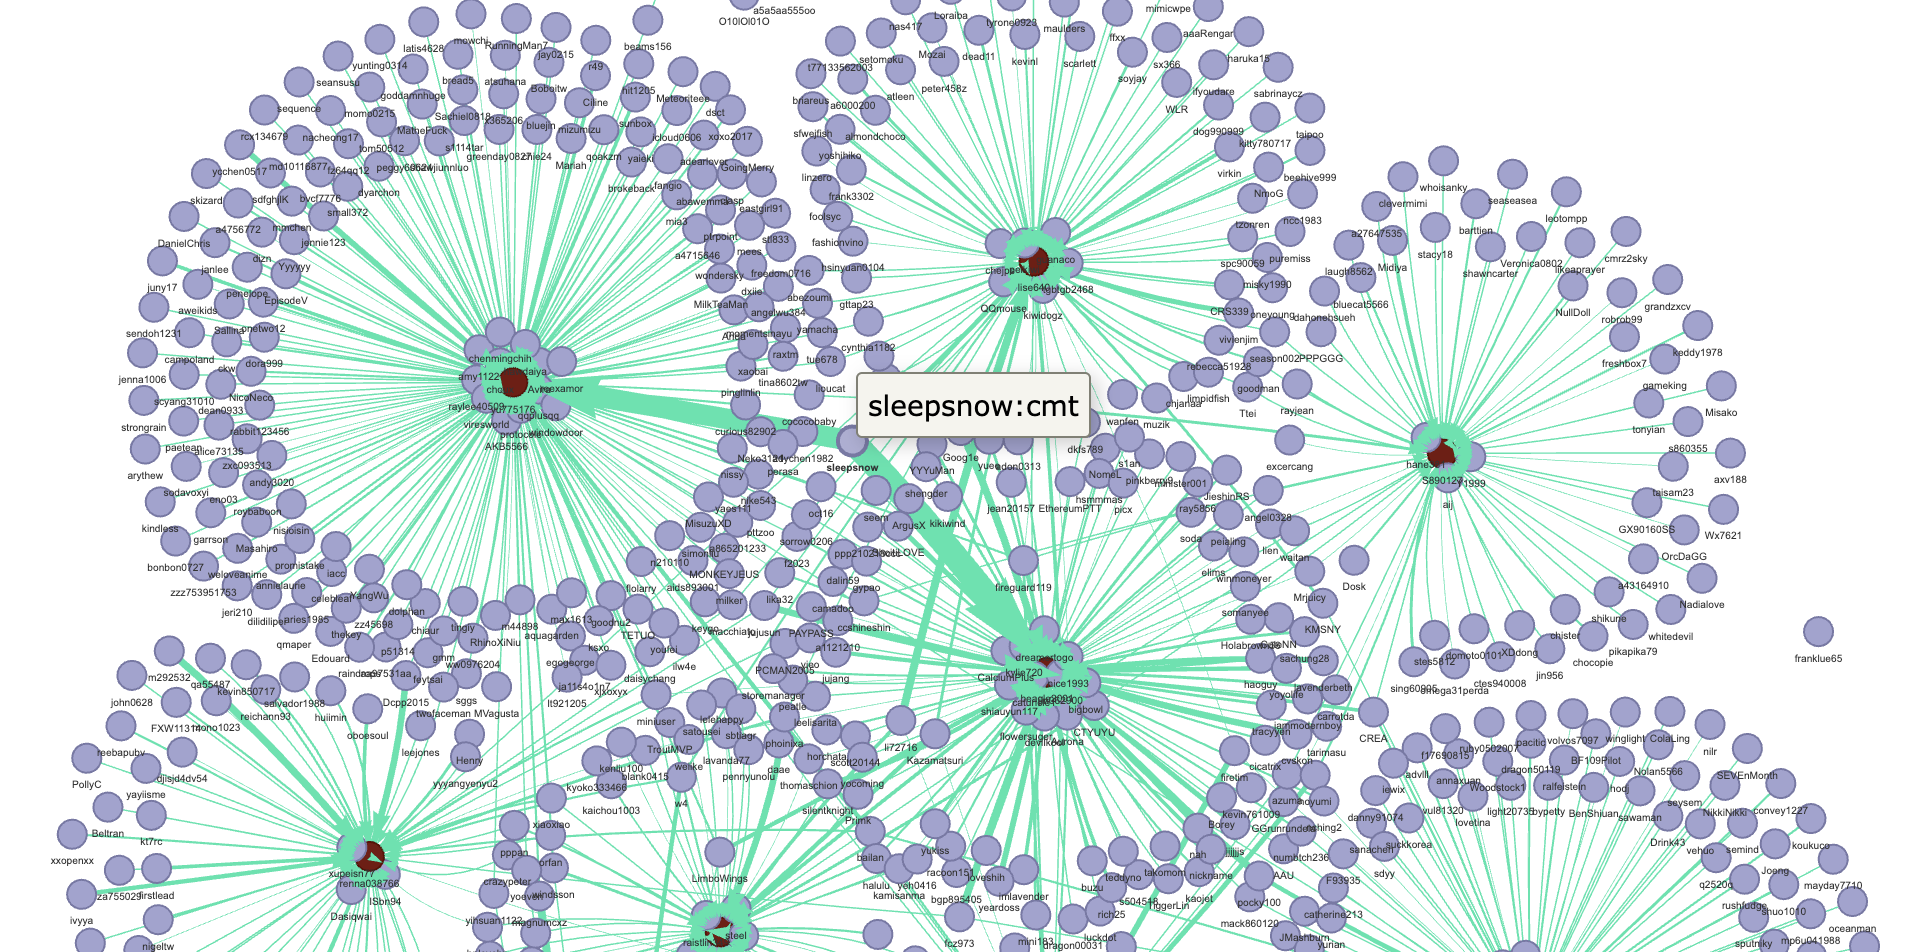

In [62]:
Image(filename='most_weight.png')

### 可以看到裡面箭頭最粗的是這位叫做 sleepsnow 的使用者, 且他對於左上和右下的討論度很高, 可能是這個版比較多意見的使用者

### 接下來, 我們想看看在這幾篇文章中, 是否能找出連結社群的人, 這些人的特徵應該是betweeness 很高, 代表他們很常在各個文章下留言

In [68]:
bet = np.array(list(nx.betweenness_centrality(nx.Graph(mat_s)).values()))
bet = (bet-np.min(bet))/(np.max(bet)-np.min(bet))
bet_q = np.quantile(bet,[.2,.4,.6,.8])

In [69]:
node_value = []
for i in bet:
  if i > bet_q[3]:
    node_value.append(25)
  elif i > bet_q[2]:
    node_value.append(20)
  elif i>bet_q[1]:
    node_value.append(15)
  elif i>bet_q[0]:
    node_value.append(10)
  else:
    node_value.append(5)

net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=node_value)
net.save_graph("./pers_bet_netWork.html")

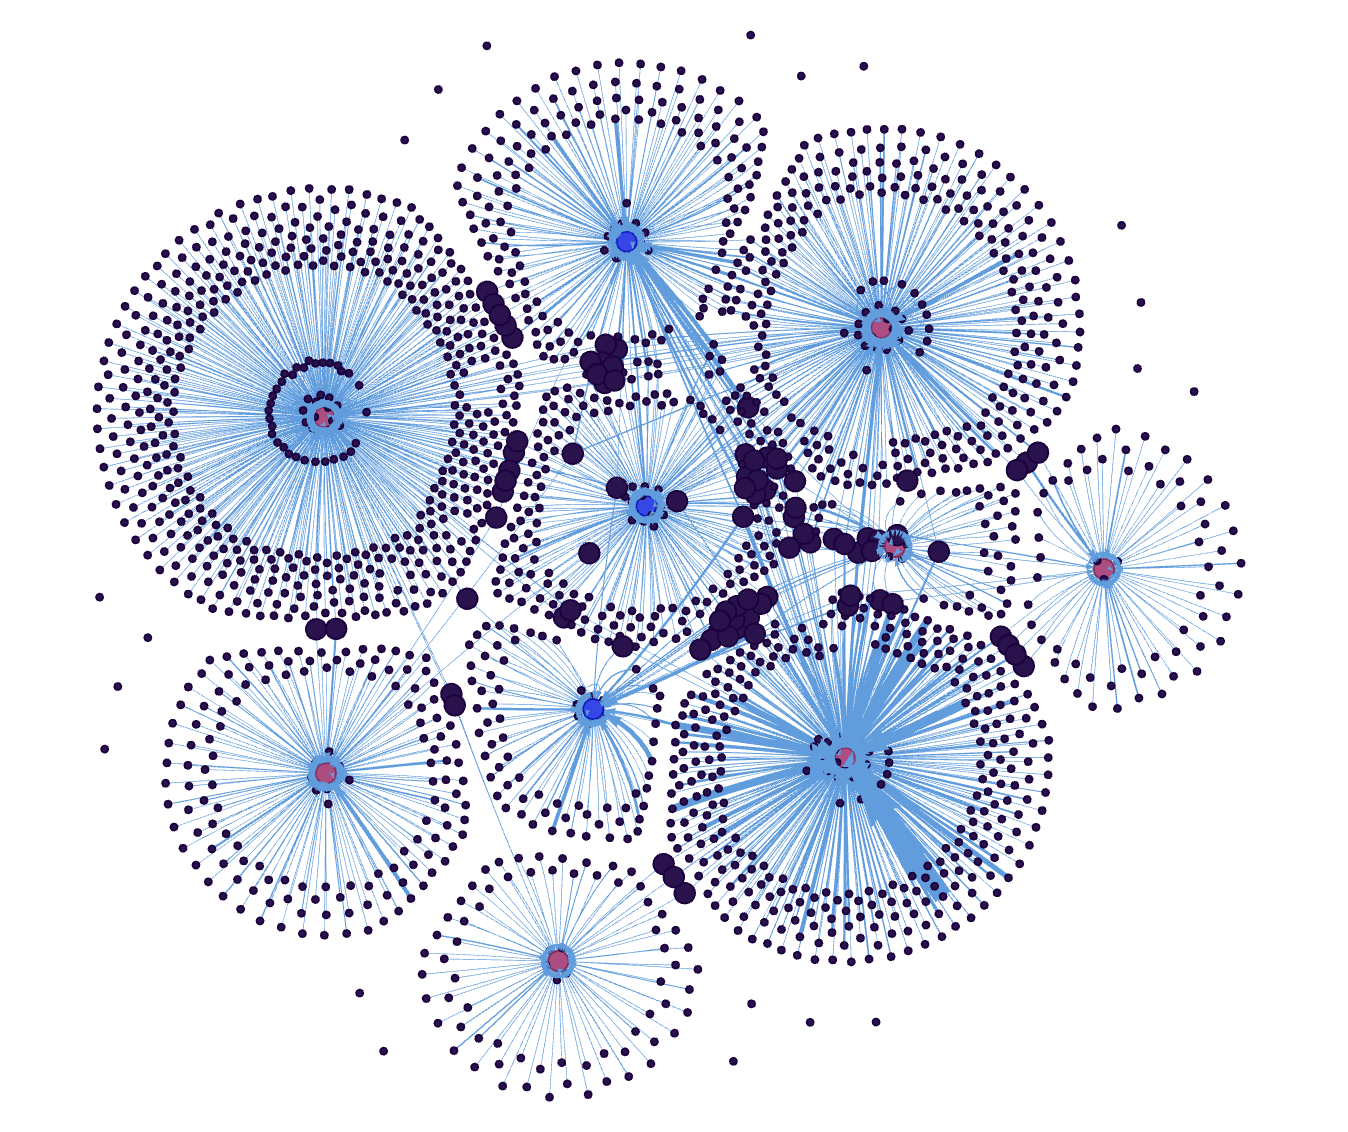

In [70]:
Image(filename='bet_network.png')

### 可以從上圖看到, 有蠻多深藍色的點, 中間還有三個藍色的po 文者同時也是評論者, 說明這個版別的人都蠻積極討論的,

### 接下來, 我們來看看最大subgraph 的圖的measure

In [71]:
# 計算max subgraph
G = nx.Graph(mat_s)
G_sub = sorted(nx.connected_components(G), key=len, reverse=True)
G_max_sub = G.subgraph(G_sub[0])
# # 重新定義 mat
sub_mat = nx.adjacency_matrix(G_max_sub).todense()
node_idx = list(G_max_sub.nodes)
sub_pers = pers[node_idx]

In [72]:
net = matPresentGraph(mat=sub_mat,node_id=sub_pers,directed=False)
net.save_graph("./max_sub.html")

matrix is Symmetric


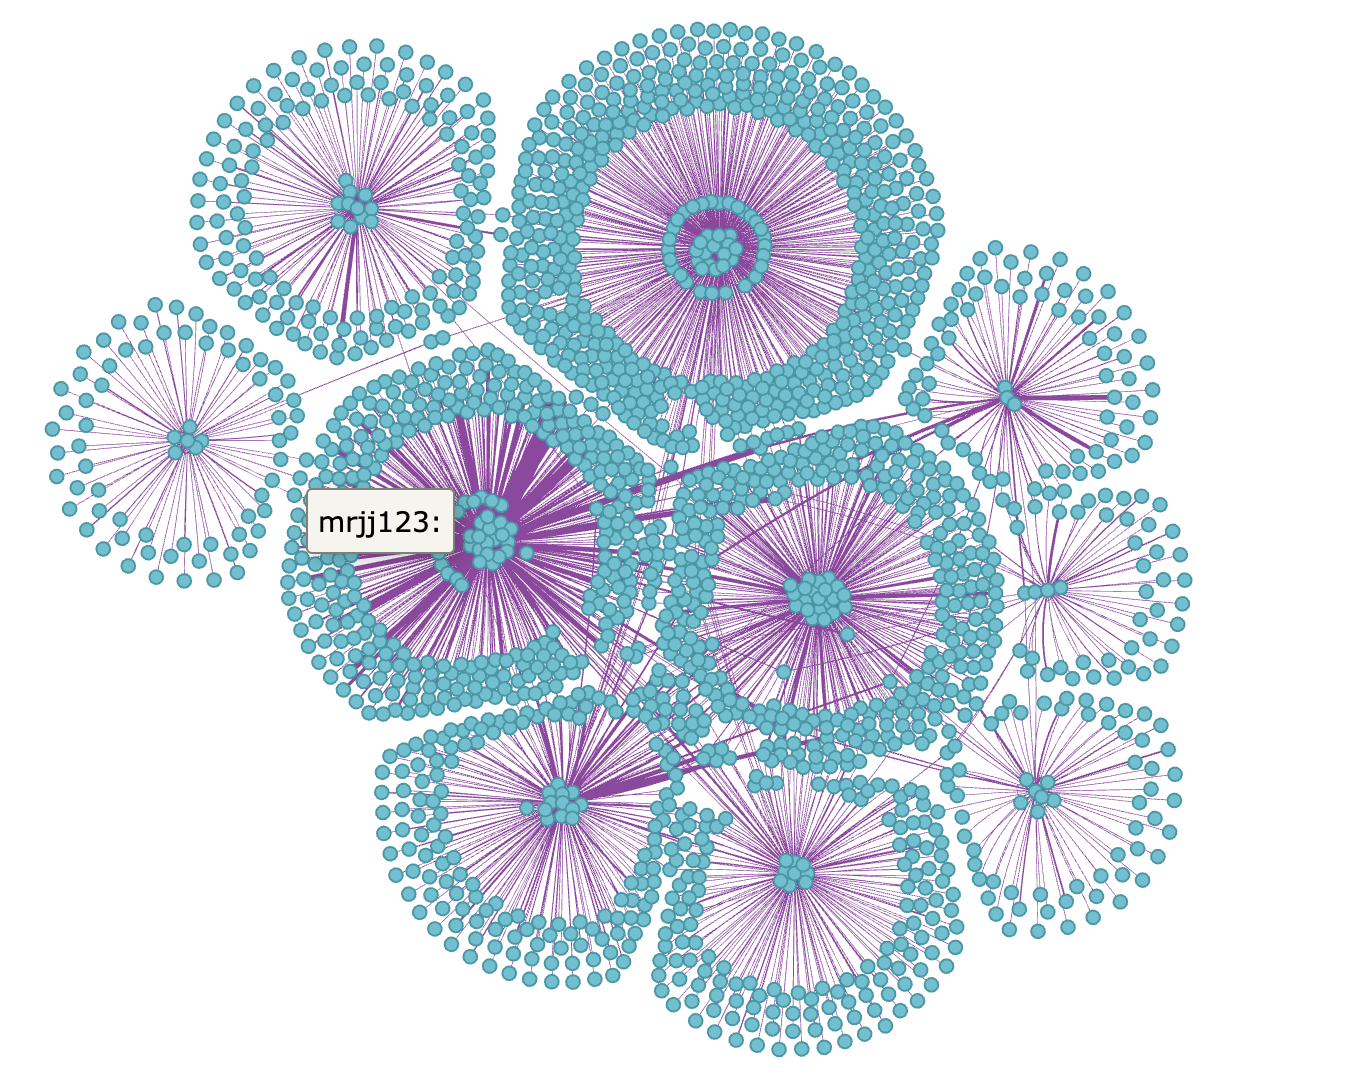

In [73]:
Image(filename='max_sub.png')

### 所有文章都有被保留下來。

### Transitivity

In [74]:
nx.transitivity(nx.Graph(sub_mat))

0.0006680882608655861

### 由於節點太多, 不會出現太多closure。

### Density

In [75]:
nx.density(nx.Graph(sub_mat))

0.00112220705044418

### Density 也是合理, node那麼多, 但大多數都只會連上文章

### Diameter

In [77]:
nx.diameter(nx.Graph(sub_mat))

6

### Diameter 是6, 代表最遠的兩個node 之間只間隔了6個點, 是符合 Small World Graph的。

### Average shortest path 

In [76]:
nx.average_shortest_path_length(nx.Graph(sub_mat))

3.77324174048043

### Clustering

In [78]:
nx.average_clustering(nx.Graph(sub_mat))

0.02512445080127836

## 6. 結論

1. 透過 LDA 主題模型分析選出最好的模型後，可以將文章分成以下四大類，可見網友主要在意的超商食品與以下幾點相關
    - 主題一：版上對於超商食物主要討論價格、熱量、內容物以及大家的評分和心得
    - 主題二：霜淇淋相關的主題
    - 主題三：主要討論麵包、甜點相關的產品
    - 主題四：咖啡相關的主題
2. 以討論的熱烈程度來說，有逐年增高的趨勢，推測大家對超商的食物越來越有興趣。
3. 有些貼文非常有趣，雖然被噓的很嚴重，但大家卻抱持著正面態度，所以在分析過程中應該仔細了解正面與負面評價的原因為何。
4. 有幾位使用者非常熱衷於超商相關的貼文討論，除了本身是發文者與評論者外，還會在多個貼文下留言。